# Week 2 Assignment: Fake News, Real NLP

## Abstract

The goal for this project was to use a dataset of news articles to create a model that determined whether a given news article was real or fake.  The dataset came from [Clement Bisaillon's Fake and real news dataset on Kaggle](https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset/), and the assignment was part of the [Tangible AI internship program](https://gitlab.com/tangibleai/team/-/blob/master/learning-resources/projects/your-first-nlp-project--detect-fake-news.md). A logistic regression model was trained on both single-variable and multi-variable models.  The final model was trained on 2 variables - title word length and number of capitalized words in the title.  This models achieved 89% accuracy.  In terms of error, 7% were false positives and 3% were false negatives.

## Import dependencies

In [63]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Load data

In [5]:
fake_news = pd.read_csv("Fake.csv")
true_news = pd.read_csv("True.csv")

## Explore data

### Get a high-level overview of data

In [6]:
fake_news.describe()

title   text subject  \
count                                               23481  23481   23481   
unique                                              17903  17455       6   
top     MEDIA IGNORES Time That Bill Clinton FIRED His...           News   
freq                                                    6    626    9050   

                date  
count          23481  
unique          1681  
top     May 10, 2017  
freq              46

In [7]:
fake_news.head()

title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date  
0  December 31, 2017  
1  December 31, 2017  
2  December 30, 2017  
3  December 29, 2017  
4  December 25, 2017

In [8]:
true_news.describe()

title  \
count                                               21417   
unique                                              20826   
top     Factbox: Trump fills top jobs for his administ...   
freq                                                   14   

                                                     text       subject  \
count                                               21417         21417   
unique                                              21192             2   
top     (Reuters) - Highlights for U.S. President Dona...  politicsNews   
freq                                                    8         11272   

                      date  
count                21417  
unique                 716  
top     December 20, 2017   
freq                   182

In [9]:
true_news.head()

title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   

                 date  
0  December 31, 2017   
1  December 29, 2017   
2  December 31, 2017   
3  December 30, 2017   
4  December 29, 2017

### Create new columns to explore data

#### Calculate and analyze title lengths

In [10]:
fake_news["title_len"] = fake_news["title"].str.len()
true_news["title_len"] = true_news["title"].str.len()

In [11]:
print("FAKE")
fake_news["title_len"].describe()
print("TRUE")
true_news["title_len"].describe()

FAKE


count    23481.000000
mean        94.198032
std         27.184433
min          8.000000
25%         77.000000
50%         90.000000
75%        105.000000
max        286.000000
Name: title_len, dtype: float64

TRUE


count    21417.000000
mean        64.667881
std          9.168999
min         26.000000
25%         59.000000
50%         64.000000
75%         70.000000
max        133.000000
Name: title_len, dtype: float64

#### Calculate and analyze the number of capitalized words in titles

In [12]:
fake_news["cap_counts"] = fake_news["title"].str.count(r"\b[A-Z][A-Z]+\b")
true_news["cap_counts"] = true_news["title"].str.count(r"\b[A-Z][A-Z]+\b")

In [13]:
print("Fake")
fake_news["cap_counts"].mean()
print("True")
true_news["cap_counts"].mean()

Fake


3.16362165154806

True


0.18051080917028528

#### Calculate and analyze the length of the articles

In [179]:
fake_news["text_len"] = fake_news["text"].str.len()
true_news["text_len"] = true_news["text"].str.len()

In [180]:
print("Fake")
fake_news["text_len"].describe()
print("True")
true_news["text_len"].describe()

Fake


count    23481.000000
mean      2547.396235
std       2532.884399
min          1.000000
25%       1433.000000
50%       2166.000000
75%       3032.000000
max      51794.000000
Name: text_len, dtype: float64

True


count    21417.000000
mean      2383.278517
std       1684.835730
min          1.000000
25%        914.000000
50%       2222.000000
75%       3237.000000
max      29781.000000
Name: text_len, dtype: float64

In [181]:
fake_news["text_len"] = fake_news["text"].str.split().str.len()
true_news["text_len"] = true_news["text"].str.split().str.len()

In [182]:
print("Fake")
fake_news["text_len"].describe()
print("True")
true_news["text_len"].describe()

Fake


count    23481.000000
mean       423.197905
std        408.388890
min          0.000000
25%        240.000000
50%        363.000000
75%        506.000000
max       8135.000000
Name: text_len, dtype: float64

True


count    21417.000000
mean       385.640099
std        274.006204
min          0.000000
25%        148.000000
50%        359.000000
75%        525.000000
max       5172.000000
Name: text_len, dtype: float64

#### Review the subjects of the articles

In [183]:
fake_news["subject"].unique()

array(['News', 'politics', 'Government News', 'left-news', 'US_News',
       'Middle-east'], dtype=object)

In [184]:
fake_news["subject"].value_counts()

News               9050
politics           6841
left-news          4459
Government News    1570
US_News             783
Middle-east         778
Name: subject, dtype: int64

In [185]:
true_news["subject"].unique()

array(['politicsNews', 'worldnews'], dtype=object)

In [186]:
true_news["subject"].value_counts()

politicsNews    11272
worldnews       10145
Name: subject, dtype: int64

The coding for the "subject" column raises concerns.  Categories seem like there could be overlap, raising concerns about how these could affect analysis.  "Politics" and "Government News" seem similar.  Also, "left-news" seems like a subset of "politics", blurring the distinction between the two.  It would have been useful to have an overview of the coding procedures and coding term explanations.

## Combine Data

### Code the original datasets

In [187]:
fake_news["category"] = 0
true_news["category"] = 1

### Produce a new dataframe

In [188]:
news_df = pd.concat([fake_news, true_news], axis=0)

In [189]:
news_df.describe(include='all')

title   text  \
count                                               44898  44898   
unique                                              38729  38646   
top     Factbox: Trump fills top jobs for his administ...          
freq                                                   14    627   
mean                                                  NaN    NaN   
std                                                   NaN    NaN   
min                                                   NaN    NaN   
25%                                                   NaN    NaN   
50%                                                   NaN    NaN   
75%                                                   NaN    NaN   
max                                                   NaN    NaN   

             subject                date     title_len    cap_counts  \
count          44898               44898  44898.000000  44898.000000   
unique             8                2397           NaN           NaN   
top     politicsNews  December 20, 2017            NaN           NaN   
freq           11272                 182           NaN           NaN   
mean             NaN                 NaN     80.111720      1.740634   
std              NaN                 NaN     25.379685      2.651166   
min              NaN                 NaN      8.000000      0.000000   
25%              NaN                 NaN     63.000000      0.000000   
50%              NaN                 NaN     73.000000      1.000000   
75%              NaN                 NaN     91.000000      3.000000   
max              NaN                 NaN    286.000000     25.000000   

            text_len      category  
count   44898.000000  44898.000000  
unique           NaN           NaN  
top              NaN           NaN  
freq             NaN           NaN  
mean      405.282284      0.477015  
std       351.265595      0.499477  
min         0.000000      0.000000  
25%       203.000000      0.000000  
50%       362.000000      0.000000  
75%       513.000000      1.000000  
max      8135.000000      1.000000

In [190]:
for col in news_df.columns:
    print(col)

title
text
subject
date
title_len
cap_counts
text_len
category


### Drop duplicate article content

Articles with duplicate content may indicate different issues.  Similar titles may just be chance due to their brief nature.  Articles with similar content may be copied from other articles, indicating they may have been plagiarized or spread across several mediums.  Additionally, it could just be a data entry error.  Creating a new data frame will allow for comparing two models - ones with duplicate value and ones without duplicate value.  Content with duplicate content (text column) will be dropped from this dataset.

In [191]:
news_df_duplicates_dropped = news_df.copy(deep=True)

In [192]:
news_df_duplicates_dropped.drop_duplicates('text', inplace=True)

In [193]:
news_df.describe(include='all')

title   text  \
count                                               44898  44898   
unique                                              38729  38646   
top     Factbox: Trump fills top jobs for his administ...          
freq                                                   14    627   
mean                                                  NaN    NaN   
std                                                   NaN    NaN   
min                                                   NaN    NaN   
25%                                                   NaN    NaN   
50%                                                   NaN    NaN   
75%                                                   NaN    NaN   
max                                                   NaN    NaN   

             subject                date     title_len    cap_counts  \
count          44898               44898  44898.000000  44898.000000   
unique             8                2397           NaN           NaN   
top     politicsNews  December 20, 2017            NaN           NaN   
freq           11272                 182           NaN           NaN   
mean             NaN                 NaN     80.111720      1.740634   
std              NaN                 NaN     25.379685      2.651166   
min              NaN                 NaN      8.000000      0.000000   
25%              NaN                 NaN     63.000000      0.000000   
50%              NaN                 NaN     73.000000      1.000000   
75%              NaN                 NaN     91.000000      3.000000   
max              NaN                 NaN    286.000000     25.000000   

            text_len      category  
count   44898.000000  44898.000000  
unique           NaN           NaN  
top              NaN           NaN  
freq             NaN           NaN  
mean      405.282284      0.477015  
std       351.265595      0.499477  
min         0.000000      0.000000  
25%       203.000000      0.000000  
50%       362.000000      0.000000  
75%       513.000000      1.000000  
max      8135.000000      1.000000

In [194]:
news_df_duplicates_dropped.describe(include='all')

title  \
count                                               38646   
unique                                              38270   
top     Factbox: Trump fills top jobs for his administ...   
freq                                                   14   
mean                                                  NaN   
std                                                   NaN   
min                                                   NaN   
25%                                                   NaN   
50%                                                   NaN   
75%                                                   NaN   
max                                                   NaN   

                                                     text       subject  \
count                                               38646         38646   
unique                                              38646             7   
top     Members of the House Intelligence Committee ar...  politicsNews   
freq                                                    1         11213   
mean                                                  NaN           NaN   
std                                                   NaN           NaN   
min                                                   NaN           NaN   
25%                                                   NaN           NaN   
50%                                                   NaN           NaN   
75%                                                   NaN           NaN   
max                                                   NaN           NaN   

                     date     title_len    cap_counts      text_len  \
count               38646  38646.000000  38646.000000  38646.000000   
unique               2397           NaN           NaN           NaN   
top     December 6, 2017            NaN           NaN           NaN   
freq                  166           NaN           NaN           NaN   
mean                  NaN     76.654427      1.332661    403.089971   
std                   NaN     22.183964      2.337116    313.828131   
min                   NaN      8.000000      0.000000      0.000000   
25%                   NaN     62.000000      0.000000    216.000000   
50%                   NaN     71.000000      0.000000    369.000000   
75%                   NaN     86.000000      2.000000    511.000000   
max                   NaN    286.000000     25.000000   8135.000000   

            category  
count   38646.000000  
unique           NaN  
top              NaN  
freq             NaN  
mean        0.548336  
std         0.497665  
min         0.000000  
25%         0.000000  
50%         1.000000  
75%         1.000000  
max         1.000000

In [195]:
news_df_duplicates_dropped["subject"].value_counts()

politicsNews       11213
worldnews           9978
News                9050
politics            6425
US_News              783
left-news            683
Government News      514
Name: subject, dtype: int64

Removing the duplicate data based on "text" still leaves some duplication in the title.  However, the duplicate titles are few.  The number of unique subjects decreased from 8 to 7.  "Middle-east" was dropped along with the duplicates, indicating that it overlapped with other news categories.

In [196]:
titles = []
duplicate_titles_list = []
for title in news_df_duplicates_dropped["title"]:
    if title in titles:
        if title not in duplicate_titles_list:
            duplicate_titles_list.append([title, news_df_duplicates_dropped["category"]])
    else:
        titles.append(title)

In [197]:
duplicate_titles_df = pd.DataFrame(duplicate_titles_list, columns=["title", "category"])
duplicate_titles_df.describe()

title  \
count                                                 376   
unique                                                340   
top     Factbox: Trump fills top jobs for his administ...   
freq                                                   13   

                                                 category  
count                                                 376  
unique                                                  1  
top     0        0
1        0
2        0
3        0
4 ...  
freq                                                  376

In [198]:
duplicate_titles_df['category'].describe()

count                                                   376
unique                                                    1
top       0        0
1        0
2        0
3        0
4 ...
freq                                                    376
Name: category, dtype: object

The remaining duplicate titles are all part of the fake news dataset.

### Mix up data

In [199]:
news_df_duplicates_dropped = news_df_duplicates_dropped.sample(frac=1)

In [200]:
news_df_duplicates_dropped

title  \
6807   Contenders for senior jobs in Trump's administ...   
13871  Chinese police detain teacher in kindergarten ...   
4567             Dear Trump: ISIS Is NOT A Football Game   
11544  Explosion outside Athens court shatters window...   
18438  Refugees' health problems in Greece mostly unm...   
...                                                  ...   
15985  Magnitude 6.4 aftershock hits off New Caledoni...   
14281  “We choose the nominee, not the people” – GOP ...   
4178    Trump Once Threatened ‘Apprentice’ Contenstan...   
1847    BREAKING: This New Analysis BAD News For Obam...   
4109    BREAKING: Trump Declares He Will Only Accept ...   

                                                    text       subject  \
6807   (Reuters) - The following are people mentioned...  politicsNews   
13871  BEIJING (Reuters) - Beijing police investigati...     worldnews   
4567   When Donald Trump talks about America, he ofte...          News   
11544  ATHENS (Reuters) - A makeshift bomb exploded o...     worldnews   
18438  ATHENS (Reuters) - Refugees and migrants in Gr...     worldnews   
...                                                  ...           ...   
15985  (Reuters) - An aftershock of magnitude 6.4 str...     worldnews   
14281   The media has created the perception that the...      politics   
4178   After it was revealed in the leaked Access Hol...          News   
1847   Paul Ryan is all over Twitter chanting  repeal...          News   
4109   Donald Trump just declared himself a threat to...          News   

                     date  title_len  cap_counts  text_len  category  
6807    December 8, 2016          52           0       656         1  
13871  November 25, 2017          59           0       257         1  
4567   September 19, 2016         40           2       801         0  
11544  December 22, 2017          60           0       192         1  
18438    October 3, 2017          65           0       403         1  
...                   ...        ...         ...       ...       ...  
15985   November 1, 2017          53           1        35         1  
14281        Mar 16, 2016         62           1       293         0  
4178     October 15, 2016         89           1       262         0  
1847        April 9, 2017         68           3       395         0  
4109     October 20, 2016         81           2       306         0  

[38646 rows x 8 columns]

## Explore full dataset

In [201]:
news_df_duplicates_dropped.isnull()

title   text  subject   date  title_len  cap_counts  text_len  category
6807   False  False    False  False      False       False     False     False
13871  False  False    False  False      False       False     False     False
4567   False  False    False  False      False       False     False     False
11544  False  False    False  False      False       False     False     False
18438  False  False    False  False      False       False     False     False
...      ...    ...      ...    ...        ...         ...       ...       ...
15985  False  False    False  False      False       False     False     False
14281  False  False    False  False      False       False     False     False
4178   False  False    False  False      False       False     False     False
1847   False  False    False  False      False       False     False     False
4109   False  False    False  False      False       False     False     False

[38646 rows x 8 columns]

<AxesSubplot:>

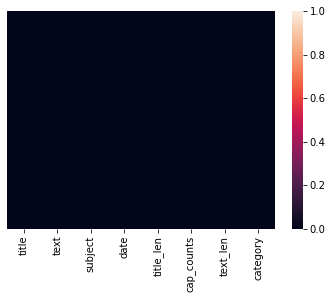

In [202]:
sns.heatmap(news_df_duplicates_dropped.isnull(), vmin=0, vmax=1, yticklabels=False)

In [203]:
news_df_duplicates_dropped.isna()

title   text  subject   date  title_len  cap_counts  text_len  category
6807   False  False    False  False      False       False     False     False
13871  False  False    False  False      False       False     False     False
4567   False  False    False  False      False       False     False     False
11544  False  False    False  False      False       False     False     False
18438  False  False    False  False      False       False     False     False
...      ...    ...      ...    ...        ...         ...       ...       ...
15985  False  False    False  False      False       False     False     False
14281  False  False    False  False      False       False     False     False
4178   False  False    False  False      False       False     False     False
1847   False  False    False  False      False       False     False     False
4109   False  False    False  False      False       False     False     False

[38646 rows x 8 columns]

<AxesSubplot:>

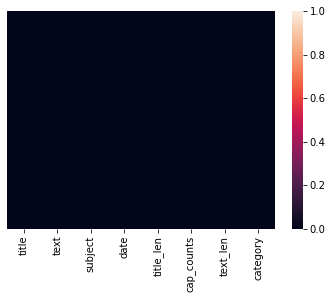

In [204]:
sns.heatmap(news_df_duplicates_dropped.isna(), vmin=0, vmax=1, yticklabels=False)

Text(0.5, 0, 'Capitalized words in title')

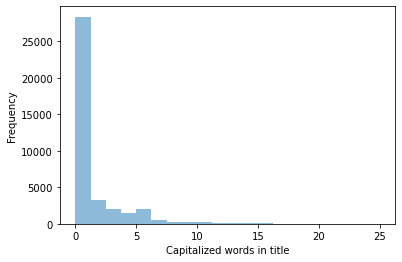

In [205]:
news_df_duplicates_dropped['cap_counts'].plot.hist(bins= 20, alpha=0.5).set_xlabel("Capitalized words in title")

Text(0.5, 0, 'Title length (in characters)')

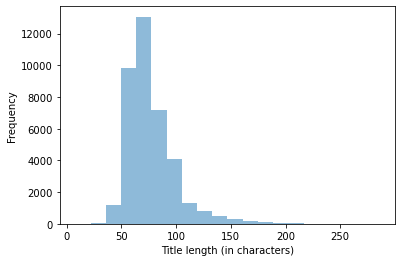

In [206]:
news_df_duplicates_dropped['title_len'].plot.hist(bins= 20, alpha=0.5).set_xlabel("Title length (in characters)")

Text(0.5, 0, 'Text length (in characters)')

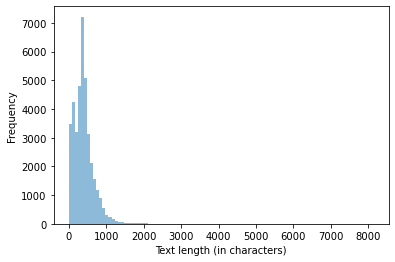

In [207]:
news_df_duplicates_dropped['text_len'].plot.hist(bins= 100, alpha=0.5).set_xlabel("Text length (in characters)")

## Create single-variable logistic regression models

### Train Cap_counts model

#### Train model

In [208]:
X = news_df_duplicates_dropped[['cap_counts']]
y = news_df_duplicates_dropped['category']

In [209]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0, stratify=news_df_duplicates_dropped['category'])

In [210]:
logistic_regression = LogisticRegression()
logistic_regression.fit(X_train, y_train)
y_pred = logistic_regression.predict(X_test)

LogisticRegression()

#### Evaluate model

In [211]:
print('Accuracy: ', metrics.accuracy_score(y_test, y_pred))

Accuracy:  0.831297867936245


Predicted     0     1
Actual               
0          3572   792
1           838  4460

<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

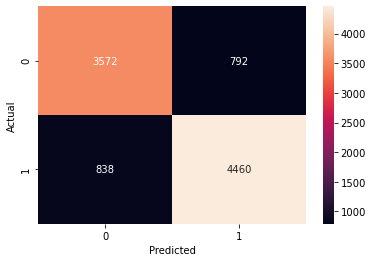

In [212]:
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
confusion_matrix
sns.heatmap(confusion_matrix, annot=True, fmt="d")

In [213]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.82      0.81      4364
           1       0.85      0.84      0.85      5298

    accuracy                           0.83      9662
   macro avg       0.83      0.83      0.83      9662
weighted avg       0.83      0.83      0.83      9662



Cap_counts seems to predict the fake news well.  However, false positives and false negatives are both high and both are about equal.

## Train Title_len model

#### Train model

In [214]:
X = news_df_duplicates_dropped[['title_len']]
y = news_df_duplicates_dropped['category']

In [215]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0, stratify=news_df_duplicates_dropped['category'])

In [216]:
logistic_regression = LogisticRegression()
logistic_regression.fit(X_train, y_train)
y_pred = logistic_regression.predict(X_test)

LogisticRegression()

#### Evaluate model

In [217]:
print('Accuracy: ', metrics.accuracy_score(y_test, y_pred))

Accuracy:  0.834920306354792


Predicted     0     1
Actual               
0          3331  1033
1           562  4736

<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

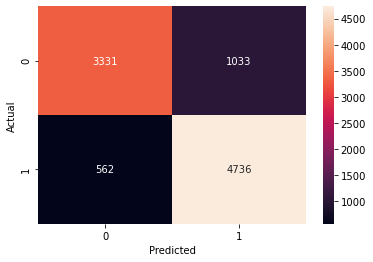

In [218]:
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
confusion_matrix
sns.heatmap(confusion_matrix, annot=True, fmt="d")

In [219]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.76      0.81      4364
           1       0.82      0.89      0.86      5298

    accuracy                           0.83      9662
   macro avg       0.84      0.83      0.83      9662
weighted avg       0.84      0.83      0.83      9662



Title_len seems to have less predictive power.  It throws more false positives than false negatives.

## Train Text_len model

#### Train model

In [220]:
X = news_df_duplicates_dropped[['text_len']]
y = news_df_duplicates_dropped['category']

In [221]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0, stratify=news_df_duplicates_dropped['category'])

In [222]:
logistic_regression = LogisticRegression()
logistic_regression.fit(X_train, y_train)
y_pred = logistic_regression.predict(X_test)

LogisticRegression()

#### Evaluate model

In [223]:
print('Accuracy: ', metrics.accuracy_score(y_test, y_pred))

Accuracy:  0.536017387704409


Predicted    0     1
Actual              
0          212  4152
1          331  4967

<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

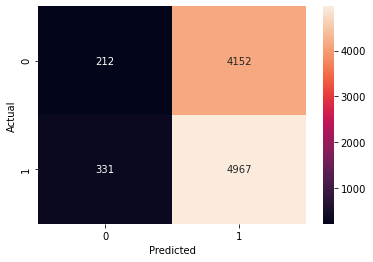

In [224]:
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
confusion_matrix
sns.heatmap(confusion_matrix, annot=True, fmt="d")

In [225]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.39      0.05      0.09      4364
           1       0.54      0.94      0.69      5298

    accuracy                           0.54      9662
   macro avg       0.47      0.49      0.39      9662
weighted avg       0.48      0.54      0.42      9662



Using character count instead of word count caused an error with the confusion matrix.  The accuracy for text_len is low at 53%.  It throws many false positives.

## Create multiple-variable logistic regression model

### Make 3-variable model

#### Train model

In [236]:
X = news_df_duplicates_dropped[['cap_counts','title_len', 'text_len']]
y = news_df_duplicates_dropped['category']

In [237]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0, stratify=news_df_duplicates_dropped['category'])

In [238]:
logistic_regression = LogisticRegression()
logistic_regression.fit(X_train, y_train)
y_pred = logistic_regression.predict(X_test)

LogisticRegression()

#### Evaluate model

In [239]:
print('Accuracy: ', metrics.accuracy_score(y_test, y_pred))

Accuracy:  0.8910163527220037


<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

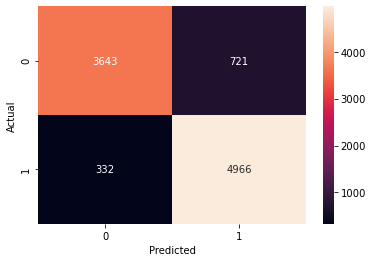

In [240]:
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, fmt="d")

In [241]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.83      0.87      4364
           1       0.87      0.94      0.90      5298

    accuracy                           0.89      9662
   macro avg       0.89      0.89      0.89      9662
weighted avg       0.89      0.89      0.89      9662



In [253]:
332 / (3643+721+332+4966)

0.03436141585593045

In [254]:
721 / (3643+721+332+4966)

0.07462223142206582

In [244]:
### Make 2-variable model

In [245]:
#### Train model

In [246]:
X = news_df_duplicates_dropped[['cap_counts','title_len']]
y = news_df_duplicates_dropped['category']

In [247]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0, stratify=news_df_duplicates_dropped['category'])

In [248]:
logistic_regression = LogisticRegression()
logistic_regression.fit(X_train, y_train)
y_pred = logistic_regression.predict(X_test)

LogisticRegression()

In [249]:
#### Evaluate model

In [250]:
print('Accuracy: ', metrics.accuracy_score(y_test, y_pred))

Accuracy:  0.889567377354585


<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

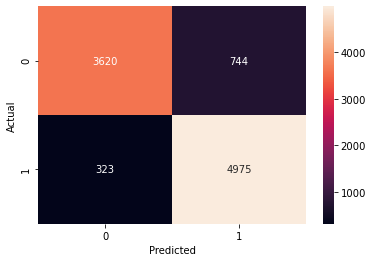

In [251]:
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, fmt="d")

In [252]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.83      0.87      4364
           1       0.87      0.94      0.90      5298

    accuracy                           0.89      9662
   macro avg       0.89      0.88      0.89      9662
weighted avg       0.89      0.89      0.89      9662



In [258]:
323/ (3620 + 744 + 323 + 4975)

0.03342993169116125

In [259]:
744/ (3620 + 744 + 323 + 4975)

0.07700269095425377

The 3-variable model scored 89%.  The 2-variable model scored 88.9%.  The accuracy, then, is similar for both models.  The 2-variable model would be preferable because it is simpler.